    Body Type     Sex         Diet How Often Shower Heating Energy Source  \
0  overweight  female  pescatarian            daily                  coal   
1       obese  female   vegetarian  less frequently           natural gas   
2  overweight    male     omnivore  more frequently                  wood   
3  overweight    male     omnivore      twice a day                  wood   
4       obese  female   vegetarian            daily                  coal   

      Transport Vehicle Type Social Activity  Monthly Grocery Bill  \
0        public          NaN           often                   230   
1  walk/bicycle          NaN           often                   114   
2       private       petrol           never                   138   
3  walk/bicycle          NaN       sometimes                   157   
4       private       diesel           often                   266   

  Frequency of Traveling by Air  Vehicle Monthly Distance Km Waste Bag Size  \
0                    frequently      

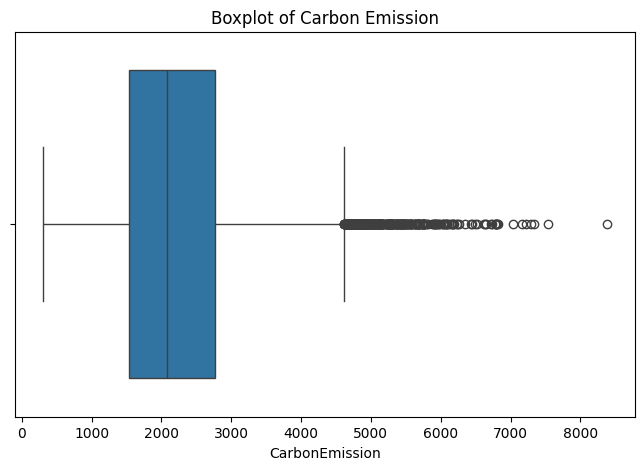

MSE: 93990.0743883
R² Score: 0.9095995755743178


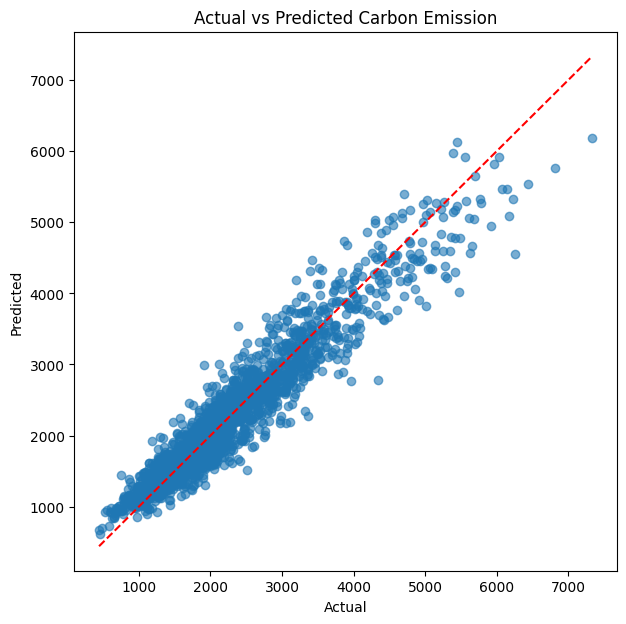

In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# =========================
# 1. Load Data
# =========================
file_path = r"C:\Users\VARUN\Desktop\Python\CarbonEmission\Carbon Emission.csv"
df = pd.read_csv(file_path)

print(df.head())
print(df.info())
print("Shape:", df.shape)
print(df.isnull().sum())

# =========================
# 2. Handle Missing / Complex Columns
# =========================
df['Vehicle Type'] = df['Vehicle Type'].fillna("unknown")

# Safely convert string lists into Python lists
for col in ['Recycling', 'Cooking_With']:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
    df[col] = df[col].apply(lambda x: x if len(x) > 0 else ['None'])

# =========================
# 3. Outlier Detection (IQR)
# =========================
Q1, Q3 = df['CarbonEmission'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

outliers = df[(df['CarbonEmission'] < lower) | (df['CarbonEmission'] > upper)]
print("Outliers detected:", outliers.shape[0])

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['CarbonEmission'])
plt.title("Boxplot of Carbon Emission")
plt.show()

# =========================
# 4. Encode Categorical Variables
# =========================

# Define label encoding columns
label_encode_cols = [
    "Body Type", "Sex", "Diet", "Heating Energy Source",
    "Transport", "Vehicle Type", "Social Activity",
    "Frequency of Traveling by Air", "Waste Bag Size", "Energy efficiency"
]

le = LabelEncoder()
for col in label_encode_cols:
    df[col + "_encoded"] = le.fit_transform(df[col])

# Ordinal Encoding for Shower Frequency
shower_mapping = {"less frequently": 0, "daily": 1, "more frequently": 2, "twice a day": 3}
df["HowOftenShower_encoded"] = df["How Often Shower"].map(shower_mapping)

# MultiLabel Encoding for multi-choice columns
mlb = MultiLabelBinarizer()

for col in ["Cooking_With", "Recycling"]:
    encoded = pd.DataFrame(mlb.fit_transform(df[col]), columns=[f"{col}_{c}" for c in mlb.classes_], index=df.index)
    df = pd.concat([df, encoded], axis=1)

# =========================
# 5. Feature Engineering
# =========================
drop_cols = ["CarbonEmission"] + label_encode_cols + ["Cooking_With", "Recycling", "How Often Shower"]
X = df.drop(columns=drop_cols)
y = df['CarbonEmission']

# =========================
# 6. Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================
# 7. Random Forest Model
# =========================
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Plot Predictions
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Carbon Emission")
plt.show()

In [3]:
import random

# Use the same features as training
random_index = random.randint(0, len(df) - 1)
random_row = X.iloc[[random_index]]   # take from X, not df

# Predict carbon emission
predicted_emission = model.predict(random_row)[0]

print("\n🎯 Random Row Selected (Index:", random_index, ")")
print(random_row)
print(f"\n✅ Predicted Carbon Emission: {predicted_emission:.2f}")
print(f"📌 Actual Carbon Emission: {y.iloc[random_index]:.2f}")



🎯 Random Row Selected (Index: 1010 )
      Monthly Grocery Bill  Vehicle Monthly Distance Km  \
1010                   202                         7598   

      Waste Bag Weekly Count  How Long TV PC Daily Hour  \
1010                       5                         19   

      How Many New Clothes Monthly  How Long Internet Daily Hour  \
1010                            44                             6   

      Body Type_encoded  Sex_encoded  Diet_encoded  \
1010                  1            0             0   

      Heating Energy Source_encoded  ...  Cooking_With_Grill  \
1010                              2  ...                   0   

      Cooking_With_Microwave  Cooking_With_None  Cooking_With_Oven  \
1010                       0                  0                  1   

      Cooking_With_Stove  Recycling_Glass  Recycling_Metal  Recycling_None  \
1010                   1                1                1               0   

      Recycling_Paper  Recycling_Plastic  
1010    

In [4]:
import joblib

# Save the trained model
joblib.dump(model, 'carbon_emission_model.joblib')
print("Model saved successfully!")

Model saved successfully!


In [18]:
def predict_carbon_emission(input_data):
    """
    Encode and predict carbon emission based on all features
    """
    # Create a DataFrame with user input
    input_df = pd.DataFrame([input_data])
    
    # Label encode categorical variables
    label_encode_cols = [
        "Body Type", "Sex", "Diet", "Heating Energy Source",
        "Transport", "Vehicle Type", "Social Activity",
        "Frequency of Traveling by Air", "Waste Bag Size", "Energy efficiency"
    ]
    
    encoded_df = input_df.copy()
    le = LabelEncoder()
    
    for col in label_encode_cols:
        # Fit on training data categories + new input to handle any new categories
        combined_data = pd.concat([df[col], pd.Series(input_data[col])])
        le.fit(combined_data)
        encoded_df[col + "_encoded"] = le.transform([input_data[col]])
    
    # Encode shower frequency
    shower_mapping = {"less frequently": 0, "daily": 1, "more frequently": 2, "twice a day": 3}
    encoded_df["HowOftenShower_encoded"] = shower_mapping[input_data["How Often Shower"]]
    
    # MultiLabel encode Cooking_With and Recycling
    mlb = MultiLabelBinarizer()
    
    for col in ["Cooking_With", "Recycling"]:
        # Fit on all possible categories from training data
        mlb.fit(df[col])
        encoded = pd.DataFrame(
            mlb.transform([input_data[col]]), 
            columns=[f"{col}_{c}" for c in mlb.classes_],
            index=encoded_df.index
        )
        encoded_df = pd.concat([encoded_df, encoded], axis=1)
    
    # Keep numerical columns as they are
    numerical_cols = [
        "Monthly Grocery Bill",
        "Vehicle Monthly Distance Km",
        "Waste Bag Weekly Count",
        "How Long TV PC Daily Hour",
        "How Many New Clothes Monthly",
        "How Long Internet Daily Hour"
    ]
    
    # Drop original categorical columns to match training data structure
    drop_cols = label_encode_cols + ["Cooking_With", "Recycling", "How Often Shower"]
    encoded_df = encoded_df.drop(columns=drop_cols)
    
    return encoded_df

# Example with all features
sample_input = {
    # Categorical features
    "Body Type": "normal",  # overweight, obese, normal, etc.
    "Sex": "female",  # Male or Female
    "Diet": "vegetarian",  # vegetarian, pescatarian, omnivore, etc.
    "How Often Shower": "more frequently",  # less frequently, daily, more frequently, twice a day
    "Heating Energy Source": "wood",  # coal, natural gas, wood, etc.
    "Transport": "private",  # public, private, walk/bicycle
    "Vehicle Type": "petrol",  # petrol, diesel, electric, or empty if no vehicle
    "Social Activity": "often",  # often, never, sometimes
    "Frequency of Traveling by Air": "frequently",  # frequently, rarely, never
    "Waste Bag Size": "medium",  # small, medium, large, extra large
    "Energy efficiency": "No",  # No, Sometimes, Yes

    # Multi-choice features
    "Cooking_With": ["Grill", "Airfryer"],  # List of cooking methods
    "Recycling": ["Plastic", "Glass", "Metal"],  # List of materials recycled
    
    # Numerical features
    "Monthly Grocery Bill": 202,  # in currency units
    "Vehicle Monthly Distance Km": 7629,  # in kilometers
    "Waste Bag Weekly Count": 1,  # number of bags per week
    "How Long TV PC Daily Hour": 17,  # hours per day
    "How Many New Clothes Monthly": 37,  # number of new clothes items
    "How Long Internet Daily Hour": 2  # hours per day
}

# Encode the input and make prediction
encoded_input = predict_carbon_emission(sample_input)
loaded_model = joblib.load('carbon_emission_model.joblib')
prediction = loaded_model.predict(encoded_input)[0]

print(f"\n🌍 Predicted Carbon Emission: {prediction:.2f}")

# Print feature importance
feature_importance = pd.DataFrame({
    'feature': encoded_input.columns,
    'importance': loaded_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\n📊 Top 10 Most Important Features:")
print(feature_importance.head(10))


🌍 Predicted Carbon Emission: 4225.37

📊 Top 10 Most Important Features:
                                  feature  importance
1             Vehicle Monthly Distance Km    0.382236
13  Frequency of Traveling by Air_encoded    0.232888
11                   Vehicle Type_encoded    0.163536
4            How Many New Clothes Monthly    0.048942
2                  Waste Bag Weekly Count    0.026812
7                             Sex_encoded    0.023093
6                       Body Type_encoded    0.022859
14                 Waste Bag Size_encoded    0.020586
9           Heating Energy Source_encoded    0.014580
0                    Monthly Grocery Bill    0.012870
